In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import time
import copy
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim.lr_scheduler as lrs

import torchvision.utils as utils
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

from IIIT5K import IIIT5K


In [2]:
vgg16 = models.vgg16(pretrained=True)

In [3]:
vocab=['-']+[chr(ord('a')+i) for i in range(26)]+[chr(ord('A')+i) for i in range(26)]+[chr(ord('0')+i) for i in range(10)]
chrToindex={}
indexTochr={}
cnt=0
for c in vocab:
    chrToindex[c]=cnt
    indexTochr[cnt]=c
    cnt+=1
vocab_size=cnt # uppercase and lowercase English characters and digits(26+26+10=62)
batch_size=16
sequence_len=28
RNN_input_dim=7168
RNN_hidden_dim=256
RNN_layer=2
RNN_type='LSTM'
RNN_dropout=0
use_VGG_extractor=False
learning_rate=(4e-3)*(0.8**0)

In [4]:
num_train=2000
train_indices=range(num_train)
num_test=3000

mytransform = T.Compose(
    [
        T.Scale((224,224)),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
IIIT5K_train = IIIT5K("IIIT5K-Word_V3.0", mytransform, train=True)
loader_train = DataLoader(dataset = IIIT5K_train,batch_size = batch_size, num_workers=2, 
                          sampler=SubsetRandomSampler(train_indices))

IIIT5K_test = IIIT5K("IIIT5K-Word_V3.0", mytransform, train=False)
loader_test = DataLoader(dataset = IIIT5K_test,batch_size = 1, num_workers=1, shuffle=True)

/home/nitin/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:207: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


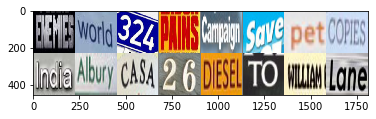

ENEMIES WORLD 324 PAINS Campaign Save pet COPIES India Albury CASA 26 DIESEL TO WILLIAM Lane


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(loader_train)
images, labels = dataiter.next()

# print(images)
# print(labels)

imshow(utils.make_grid(images))
print(' '.join('%s' % labels[j] for j in range(batch_size)))

In [6]:
print('CUDA available :',torch.cuda.is_available())
cpu_dtype = torch.FloatTensor # the CPU datatype
gpu_dtype = torch.cuda.FloatTensor # the GPU datatype

dtype=gpu_dtype
print(dtype)

# From torchvision/vgg.py
def reset(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal(m.weight, gain=1)
#             n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#             m.weight.data.normal_(0, math.sqrt(2. / n))
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal(m.weight, gain=1)
#             m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()
        elif hasattr(m, 'reset_parameters'):
            m.reset_parameters()
            
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

CUDA available : True
<class 'torch.cuda.FloatTensor'>


In [7]:
class CNN_block(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(CNN_block, self).__init__()
        self.conv_1=nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.conv_2=nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.conv_3=nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.batchnorm1=nn.BatchNorm2d(num_features=out_channel)
        self.batchnorm2=nn.BatchNorm2d(num_features=out_channel)
        self.batchnorm3=nn.BatchNorm2d(num_features=out_channel)
        self.relu=nn.ReLU(True)
        self.maxpool=nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        
    def forward(self, x):
        x=self.relu(self.batchnorm1(self.conv_1(x)))
        x=self.relu(self.batchnorm2(self.conv_2(x)))
        x=self.relu(self.batchnorm3(self.conv_3(x)))
        x=self.maxpool(x)
        return x
    
class ToRNN(nn.Module):
    def forward(self, x):
        x=x.permute(3,0,1,2)
        W,N,C,H= x.size()
        x.contiguous()
        return x.view(W,N,-1)
    
class BiDireRNN(nn.Module):
    def __init__(self):
        super(BiDireRNN, self).__init__()
        self.hidden_dim = RNN_hidden_dim
        self.num_layers=RNN_layer
        self.sql=sequence_len
        self.bsize=batch_size
        self.dropout=RNN_dropout
        self.rnn_type=RNN_type
        self.rnn = self.rnn_layer()
        self.hidden=None
        self.init_hidden(batch_size)
        
    def rnn_layer(self):
        if self.rnn_type=='RNN':
            return nn.RNN(RNN_input_dim, self.hidden_dim, self.num_layers, dropout=self.dropout, bidirectional=True)
        elif self.rnn_type=='LSTM':
            return nn.LSTM(RNN_input_dim, self.hidden_dim, self.num_layers, dropout=self.dropout, bidirectional=True)
        elif self.rnn_type=='GRU':
            return nn.GRU(RNN_input_dim, self.hidden_dim, self.num_layers, dropout=self.dropout, bidirectional=True)
        else:
            raise AssertionError('unknown RNN type:',self.rnn_type)
    
    def init_hidden(self,bsize):
        if self.rnn_type=='LSTM':
            self.hidden=(Variable(torch.zeros(self.num_layers*2, bsize, self.hidden_dim).type(dtype)),
                    Variable(torch.zeros(self.num_layers*2, bsize, self.hidden_dim).type(dtype)))
        else:
            self.hidden=Variable(torch.zeros(self.num_layers*2, bsize, self.hidden_dim).type(dtype))
        
    
    def forward(self, x):
        rnn_out, self.hidden = self.rnn(x, self.hidden)
        return rnn_out
        

class Model(nn.Module):
    def __init__(self,use_VGG_extractor=False):
        super(Model, self).__init__()
        if use_VGG_extractor:
            self.feature_extractor=nn.Sequential(*([vgg16.features[i] for i in range(17)]))
            for param in self.feature_extractor.parameters():
                param.requires_grad=False
                
        else:
            self.feature_extractor=nn.Sequential(*([CNN_block(3,64),CNN_block(64,128),CNN_block(128,256)]))
        self.toRNN=ToRNN()
        self.RNN=BiDireRNN()
        self.toTraget=nn.Linear(RNN_hidden_dim*2, vocab_size)
        self.softmax=nn.Softmax(dim=2)

    def forward(self, x):
        feature=self.feature_extractor(x)
        RNN_input=self.toRNN(feature)
        RNN_out=self.RNN(RNN_input)
        tag_scores = self.toTraget(RNN_out)
        return tag_scores

In [8]:
my_model=Model(use_VGG_extractor=use_VGG_extractor).type(dtype)
print(my_model)
for param in my_model.named_parameters():
    print(param[0],type(param[1].data),param[1].size(),param[1].requires_grad)

loss_function = torch.nn.CTCLoss().type(dtype)
# opt_parameters=my_model.parameters() if use_VGG_extractor==False else [my_model.RNN.parameters(),my_model.toTraget.parameters()]
# print(opt_parameters)
# optimizer = optim.Adam(opt_parameters, lr=4e-3)

if use_VGG_extractor:
    opt_parameters=list(my_model.RNN.parameters())+list(my_model.toTraget.parameters())
    optimizer = optim.Adam(iter(opt_parameters), lr=learning_rate)
else:
    optimizer = optim.Adam(my_model.parameters(), lr=learning_rate)

scheduler = lrs.StepLR(optimizer, step_size=20, gamma=0.8)

Model(
  (feature_extractor): Sequential(
    (0): CNN_block(
      (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1): CNN_block(
      (conv_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pa

In [9]:
def model_train(max_epoch,print_every):

    iter_each_epoch=num_train//batch_size
    loss_his_train=[]

    for epoch in range(max_epoch):
        scheduler.step()
        my_model.train()
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
              'start epoch %d/%d:' % (epoch+1,max_epoch),'learning_rate =',scheduler.get_lr()[0],
              'sequence_len =',my_model.RNN.sql)
        tot_loss=0
        
        it=0
        for images,labels in loader_train:

            X_var=Variable(images.type(dtype))
            
            out_size=Variable(torch.IntTensor([sequence_len] * batch_size))
            y_size=Variable(torch.IntTensor([len(l) for l in labels]))
            conc_label=''.join(labels)
            y=[chrToindex[c] for c in conc_label]
            y_var=Variable(torch.IntTensor(y))

            my_model.zero_grad()

            my_model.RNN.init_hidden(batch_size)

            scores = my_model(X_var)

            loss = loss_function(scores,y_var,out_size,y_size)/batch_size
            loss.backward()
            optimizer.step()
            
            tot_loss+=loss.data.item()
            
            if it==0 or (it+1)%print_every==0 or it==iter_each_epoch-1:
                print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                      'iter %d loss = %f' % (it+1,loss.data.item()))
            it+=1
                
        tot_loss/=iter_each_epoch
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                'epoch %d/%d average_loss = %f\n' % (epoch+1,max_epoch,tot_loss))
        loss_his_train.append(tot_loss)
    return loss_his_train

In [10]:
my_model.apply(reset)
# my_model.load_state_dict(torch.load('parameters-5000'))
my_model.train()
my_model.RNN.init_hidden(batch_size)
loss_his_train=model_train(max_epoch=2,print_every=25)

2019-12-06 12:47:00 start epoch 1/2: learning_rate = 0.004 sequence_len = 28


/home/nitin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  if sys.path[0] == '':
/home/nitin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


2019-12-06 12:47:01 iter 1 loss = 2.364344
2019-12-06 12:47:19 iter 25 loss = 0.313278
2019-12-06 12:47:35 iter 50 loss = 0.286593
2019-12-06 12:47:51 iter 75 loss = 0.280307
2019-12-06 12:48:07 iter 100 loss = 0.287175
2019-12-06 12:48:23 iter 125 loss = 0.270158
2019-12-06 12:48:23 epoch 1/2 average_loss = 0.310622

2019-12-06 12:48:23 start epoch 2/2: learning_rate = 0.004 sequence_len = 28
2019-12-06 12:48:24 iter 1 loss = 0.299791
2019-12-06 12:48:39 iter 25 loss = 0.263703
2019-12-06 12:48:55 iter 50 loss = 0.277653
2019-12-06 12:49:11 iter 75 loss = 0.260023
2019-12-06 12:49:27 iter 100 loss = 0.292002
2019-12-06 12:49:44 iter 125 loss = 0.256435
2019-12-06 12:49:44 epoch 2/2 average_loss = 0.279286



In [11]:
# save parameters
torch.save(my_model.state_dict(), 'parameters-5000')

# load parameters
# my_model.load_state_dict(torch.load('parameters'))

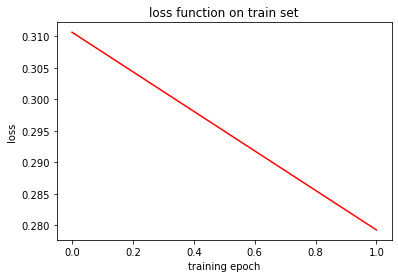

In [12]:
plt.figure(1)
ptr,=plt.plot(range(len(loss_his_train)),loss_his_train,'r-')
plt.xlabel('training epoch')
plt.ylabel('loss')
plt.title('loss function on train set')
# plt.legend((ptr),('train'))
plt.savefig('model-l.png')
plt.show()

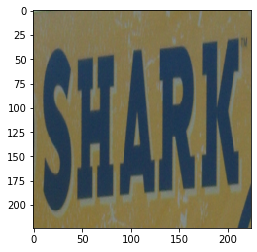

SHARK
(1, 256, 28, 28)


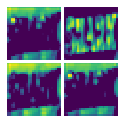

----------------------------
tensor([[[ 4.0970, -0.2470, -1.1345,  ..., -1.8054, -1.7106, -1.1533]],

        [[ 5.0203,  0.3283, -1.3729,  ..., -2.0605, -1.8499, -1.3061]],

        [[ 5.3793,  0.4564, -1.4381,  ..., -2.2078, -1.9378, -1.4117]],

        ...,

        [[ 5.4493,  0.4738, -1.5204,  ..., -2.2464, -2.0486, -1.4176]],

        [[ 5.4148,  0.4013, -1.5964,  ..., -2.1658, -2.0468, -1.4101]],

        [[ 4.9248,  0.3126, -1.5200,  ..., -1.9664, -1.8411, -1.3196]]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([45, 34, 27, 44, 37], dtype=torch.int32)
4.009696960449219


In [13]:
dataiter = iter(loader_test)
image_test, label_test = dataiter.next()

imshow(utils.make_grid(image_test))
print(label_test[0])

x_var_test = Variable(image_test.type(dtype))
out=my_model.feature_extractor(x_var_test)
feature_map=out.cpu().data.numpy()
print(feature_map.shape)
sample_index=np.random.choice(256,4)
plt.figure(figsize = (2,2))
gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(4):
    plt.subplot(gs1[i])
    feature_submap=feature_map[0,sample_index[i],:,:]
    plt.imshow(feature_submap)
    plt.axis('off')
plt.show()

my_model.RNN.init_hidden(1)
result=my_model(x_var_test)
result_np=result.cpu().data.numpy()
result_word=''
for i in range(sequence_len):
    ch=np.argmax(result_np[i,0,:])
    result_word+=indexTochr[ch]
print(result_word)

out_size=Variable(torch.IntTensor([sequence_len]))
y_size=Variable(torch.IntTensor([len(l) for l in label_test]))
conc_label=''.join(label_test)
y=[chrToindex[c] for c in conc_label]
y_var=Variable(torch.IntTensor(y))
loss=loss_function(result,y_var,out_size,y_size)
print(result)
print(y_var)
print(loss.data.item())